<a href="https://colab.research.google.com/github/em-chiu/intersection_project/blob/main/EC%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import urllib.request
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
import numpy as np
from collections import Counter
from sklearn import preprocessing
import string
nltk.download('averaged_perceptron_tagger') # to solve pos feature extract issue
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

import pandas as pd # data processing
import csv
import sys
import unidecode
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/emilychiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load the data to df, try1 works
df = pd.read_csv('sexistinfo.csv', header=None, encoding = "ISO-8859-1").drop(0, axis=1)

In [3]:
# preview data
df.head()

,1,2
0,text,label
1,@MirkoPlsll @IanisRondeau ouais.. un chef d'oe...,0
2,@MamzelleMNa Une trÃ¨s humble femme! #Ironie,0
3,"BLOGUE - Â«TsÃ©, la paritÃ© homme-femme...Â» a...",0
4,Je suis une femme matÃ©rialiste et superficiel...,0


In [4]:
# Drop first row 
# by selecting all rows from first row onwards
df = df.iloc[1: , :]

In [5]:
# view dimensions of dataset
df.shape
# 9341 instances and 2 attributes in dataset

(9341, 2)

In [6]:
# Rename column names
col_names = ['tweet', 'label']
df.columns = col_names
df.columns

Index(['tweet', 'label'], dtype='object')

In [7]:
# preview after renaming
df.head()

,tweet,label
1,@MirkoPlsll @IanisRondeau ouais.. un chef d'oe...,0
2,@MamzelleMNa Une trÃ¨s humble femme! #Ironie,0
3,"BLOGUE - Â«TsÃ©, la paritÃ© homme-femme...Â» a...",0
4,Je suis une femme matÃ©rialiste et superficiel...,0
5,Mise en ligne de mon article sur @PayeTaShnek ...,0


In [8]:
# summary of data
df.info()
# no missing data
# Categorical variables have data type object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9341 entries, 1 to 9341
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   9340 non-null   object
 1   label   9330 non-null   object
dtypes: object(2)
memory usage: 146.1+ KB


In [9]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 2 categorical variables

The categorical variables are :

 ['tweet', 'label']


In [10]:
# view the categorical variables
df[categorical].head()

,tweet,label
1,@MirkoPlsll @IanisRondeau ouais.. un chef d'oe...,0
2,@MamzelleMNa Une trÃ¨s humble femme! #Ironie,0
3,"BLOGUE - Â«TsÃ©, la paritÃ© homme-femme...Â» a...",0
4,Je suis une femme matÃ©rialiste et superficiel...,0
5,Mise en ligne de mon article sur @PayeTaShnek ...,0


In [11]:
# check missing values in categorical variables
df[categorical].isnull().sum()

# drop values (in processing)

tweet     1
label    11
dtype: int64

In [12]:
df.dropna(inplace = True)
# drop a rows whose all data is missing or contain null values(NaN) 
# in place changes df

In [13]:
df.info()
# after dropping rows w/ nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9330 entries, 1 to 9341
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   9330 non-null   object
 1   label   9330 non-null   object
dtypes: object(2)
memory usage: 218.7+ KB


In [14]:
# view frequency counts of values in categorical variables
for var in categorical: 
    print(df[var].value_counts())

#0    6330
#1    3000

Le 25 janvier se tiendra la premiÃ¨re JournÃ©e contre le sexisme #EnsembleContreLeSexisme https://t.co/AeT5xrm83W via @latribune                                                                                                                                                                                          8
@frhaz @partisocialiste @RachidTemal Le test du sondage par le tweet inutile aprÃ¨s 10j de silence est echec Freddy ! #Degage #BalanceTonPorc                                                                                                                                                                             6
#journeedesdroitsdesfemmes \nVoici le flot d immondices que reÃ§oit @Simonnet2 sur Twitter \nÃ gerber ð¤¢\n#Balancetonporc https://t.co/7tm8VsLICh                                                                                                                                                                      4
ð´@Monier_eric qui dirige aujourd'hui la rÃ©dactio

In [15]:
# view frequency distribution of categorical variables
for var in categorical:   
    print(df[var].value_counts()/float(len(df)))

Le 25 janvier se tiendra la premiÃ¨re JournÃ©e contre le sexisme #EnsembleContreLeSexisme https://t.co/AeT5xrm83W via @latribune                                                                                                                                                                                          0.000857
@frhaz @partisocialiste @RachidTemal Le test du sondage par le tweet inutile aprÃ¨s 10j de silence est echec Freddy ! #Degage #BalanceTonPorc                                                                                                                                                                             0.000643
#journeedesdroitsdesfemmes \nVoici le flot d immondices que reÃ§oit @Simonnet2 sur Twitter \nÃ gerber ð¤¢\n#Balancetonporc https://t.co/7tm8VsLICh                                                                                                                                                                      0.000429
ð´@Monier_eric qui dirige auj

In [16]:
# # check frequency distribution of values in label variable
df.label.value_counts()

0    6330
1    3000
Name: label, dtype: int64

In [17]:
# Lowercase all words
def make_lower(a_string):
    return a_string.lower()

df['lowered_tweet'] = df['tweet'].apply(make_lower)
df['lowered_tweet']

1       @mirkoplsll @ianisrondeau ouais.. un chef d'oe...
2            @mamzellemna une trã¨s humble femme! #ironie
3       blogue - â«tsã©, la paritã© homme-femme...â» a...
4       je suis une femme matã©rialiste et superficiel...
5       mise en ligne de mon article sur @payetashnek ...
                              ...                        
9337    #sã©golã¨neroyal a participã© activement au dã...
9338    depuis l'affaire dsk, les fã©ministes ne veule...
9339    analogie. câest comme dire ã  une femme, vou...
9340    si t'as une bite a la place du coeur, t'ã©tonn...
9341    @admir_fdlrc @cardoso_lisa @nadine__morano au ...
Name: lowered_tweet, Length: 9330, dtype: object

In [18]:
tokenizer = nltk.TweetTokenizer()
# keeps hashtags together, subset of word_tokenize

df['tokenized_tweet'] = df['lowered_tweet'].apply(tokenizer.tokenize)
df.head()

# https://stackoverflow.com/questions/48363461/passing-a-pandas-dataframe-column-to-an-nltk-tokenizer
#df['tweet'] = df['tweet'].apply(nltk.TweetTokenizer)
# this overwrote what i did

,tweet,label,lowered_tweet,tokenized_tweet
1,@MirkoPlsll @IanisRondeau ouais.. un chef d'oe...,0,@mirkoplsll @ianisrondeau ouais.. un chef d'oe...,"[@mirkoplsll, @ianisrondeau, ouais, .., un, ch..."
2,@MamzelleMNa Une trÃ¨s humble femme! #Ironie,0,@mamzellemna une trã¨s humble femme! #ironie,"[@mamzellemna, une, trã, ¨, s, humble, femme, ..."
3,"BLOGUE - Â«TsÃ©, la paritÃ© homme-femme...Â» a...",0,"blogue - â«tsã©, la paritã© homme-femme...â» a...","[blogue, -, â, «, tsã, ©, ,, la, paritã, ©, ho..."
4,Je suis une femme matÃ©rialiste et superficiel...,0,je suis une femme matã©rialiste et superficiel...,"[je, suis, une, femme, matã, ©, rialiste, et, ..."
5,Mise en ligne de mon article sur @PayeTaShnek ...,0,mise en ligne de mon article sur @payetashnek ...,"[mise, en, ligne, de, mon, article, sur, @paye..."


In [19]:
# df['tweet'] = df['tweet'].astype(pd.StringDtype())

# df['tokenized_tweet_joined'] = df['tokenized_tweet'].astype(str)
# # must feed str into vectorizer

def rejoin_string(a_list):
    return ' '.join(a_list)


df['tokenized_tweet_joined'] = df['tokenized_tweet'].apply(rejoin_string)
# rejoins into string, that's been tokenized
# holds spaces between tokens but now altogether

In [20]:
df.head()

,tweet,label,lowered_tweet,tokenized_tweet,tokenized_tweet_joined
1,@MirkoPlsll @IanisRondeau ouais.. un chef d'oe...,0,@mirkoplsll @ianisrondeau ouais.. un chef d'oe...,"[@mirkoplsll, @ianisrondeau, ouais, .., un, ch...",@mirkoplsll @ianisrondeau ouais .. un chef d'o...
2,@MamzelleMNa Une trÃ¨s humble femme! #Ironie,0,@mamzellemna une trã¨s humble femme! #ironie,"[@mamzellemna, une, trã, ¨, s, humble, femme, ...",@mamzellemna une trã ¨ s humble femme ! #ironie
3,"BLOGUE - Â«TsÃ©, la paritÃ© homme-femme...Â» a...",0,"blogue - â«tsã©, la paritã© homme-femme...â» a...","[blogue, -, â, «, tsã, ©, ,, la, paritã, ©, ho...","blogue - â « tsã © , la paritã © homme-femme ...."
4,Je suis une femme matÃ©rialiste et superficiel...,0,je suis une femme matã©rialiste et superficiel...,"[je, suis, une, femme, matã, ©, rialiste, et, ...",je suis une femme matã © rialiste et superfici...
5,Mise en ligne de mon article sur @PayeTaShnek ...,0,mise en ligne de mon article sur @payetashnek ...,"[mise, en, ligne, de, mon, article, sur, @paye...",mise en ligne de mon article sur @payetashnek ...


In [21]:
X = df['tokenized_tweet_joined'] # list of tokenized tweets
y = df['label'] # list of labels of tweets

In [22]:
# split X and y into training and testing sets
# randomizes data in splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# indicating random state ensures data split will be same
#https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn

In [23]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape
# ((7464,), (1866,))

((7464,), (1866,))

In [24]:
y_train.shape, y_test.shape
#((7464,), (1866,))

((7464,), (1866,))

In [25]:
# check data types in X_train

X_train.dtypes

dtype('O')

In [26]:
# stopwords_fr = nltk.corpus.stopwords.words("french")
# https://stackoverflow.com/questions/57359982/remove-stopwords-in-french-and-english-in-tfidfvectorizer

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize our vectorizer (featurizer, turning text to numbers)
#only looking at numbers produced, creating features
# takes each tweet turning into feature vector, each column corresponds to word
vectorizer = TfidfVectorizer(ngram_range=(1,3))

# fit vectorizer w/ train data (training data)
# This makes your vocab matrix, learns words in vocab
vectorizer.fit(X_train)

# This transforms your documents into vectors (numbers).
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [28]:
# function to test and evaluate models. 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# For plotting
import matplotlib.pyplot as plt

def build_and_eval_model(model, X, y):
    print("Running report for model:", model) 
    
    # Fit our model.
    model.fit(X_train, y_train)
    
    
    # predicting results based on testing data
    y_pred = model.predict(X_test)
    # Make predicted probabilites of our testing data
#     y_pred_proba = model.predict_proba(X_test)
# https://stackoverflow.com/questions/15111408/how-does-sklearn-svm-svcs-function-predict-proba-work-internally

    # Get the evaluation metrics 
    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    # y_test are true class labels and y_pred are predicted class labels in test-set, don't use train data
    
    # f1-score is always lower than accuracy measures, they embed precision and recall into their computation
#     print('F1 Score: %.4f' % f1_score(y_test, y_pred, pos_label='0'))
    # https://datascience.stackexchange.com/questions/54436/valueerror-pos-label-1-is-not-a-valid-label-arrayn-y-dtype-u1
    # data not much, low f1score; cross fold validation to generate data articificially
    f1score = f1_score(y_test, y_pred, average='macro')
    print('macro F-1 score : {}'.format(np.round(f1score,5)))
    # macro avg f1score = unweighted mean of all the per-class F1 scores, treats all classes equally important
    # weighted-averaged F1 score is calculated by taking the mean of all per-class F1 scores while considering each class’s support
    ## ‘weight’ refers to proportion of each class’s support relative to the sum of all support values
    # https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
    
    # compare the train-set and test-set accuracy to check for overfitting 
    y_pred_train = model.predict(X_train) 
    # overlearned training data = training accuracy higher (but not over so b/c not 99)
    ## close enough to "possibly" overfit but not dramatic difference --> trust model accuracy score (minor point)
    print('Training set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
    print('Test set accuracy score: {:.4f}'.format(model.score(X_test, y_test)))

    # Print the classification report. 
    print(metrics.classification_report(y_test, y_pred))
    
        
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(13,13))
    
    metrics.plot_confusion_matrix(estimator=model, 
                                  X=X_test, 
                                  y_true=y_test, 
                                  ax=ax)
    
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])

#     # visualize confusion matrix with seaborn heatmap
#     cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
#                                  index=['Predict Positive:1', 'Predict Negative:0'])
#     sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    
    
    # print classification accuracy, same as test set score & model accuracy score
    classification_accuracy = (cm[0,0] + cm[1,1]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
    
    # print classification error
    classification_error = (cm[0,1] + cm[1,0]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('Classification error : {0:0.4f}'.format(classification_error))

    # Return the fitted model. 
    return model


Running report for model: LogisticRegression()
Model accuracy score: 0.7728
macro F-1 score : 0.71293
Training set accuracy score: 0.8792
Test set accuracy score: 0.7728
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1278
           1       0.69      0.50      0.58       588

    accuracy                           0.77      1866
   macro avg       0.74      0.70      0.71      1866
weighted avg       0.76      0.77      0.76      1866

Confusion matrix

 [[1147  131]
 [ 293  295]]

True Positives(TP) =  1147

True Negatives(TN) =  295

False Positives(FP) =  131

False Negatives(FN) =  293
Classification accuracy : 0.7728
Classification error : 0.2272


LogisticRegression()

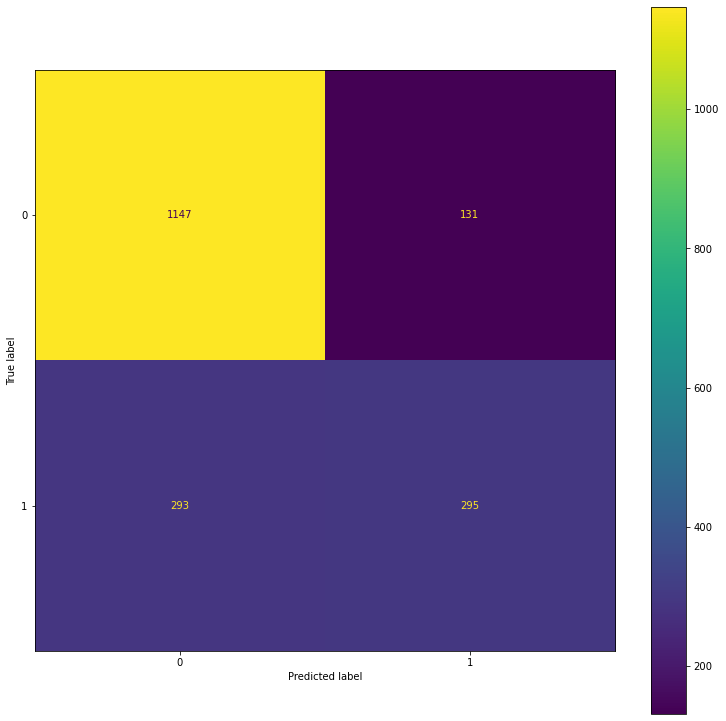

In [29]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
build_and_eval_model(lr, X, y)

Running report for model: LinearSVC()
Model accuracy score: 0.7964
macro F-1 score : 0.76823
Training set accuracy score: 0.9918
Test set accuracy score: 0.7964
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1278
           1       0.67      0.71      0.69       588

    accuracy                           0.80      1866
   macro avg       0.76      0.77      0.77      1866
weighted avg       0.80      0.80      0.80      1866

Confusion matrix

 [[1068  210]
 [ 170  418]]

True Positives(TP) =  1068

True Negatives(TN) =  418

False Positives(FP) =  210

False Negatives(FN) =  170
Classification accuracy : 0.7964
Classification error : 0.2036


LinearSVC()

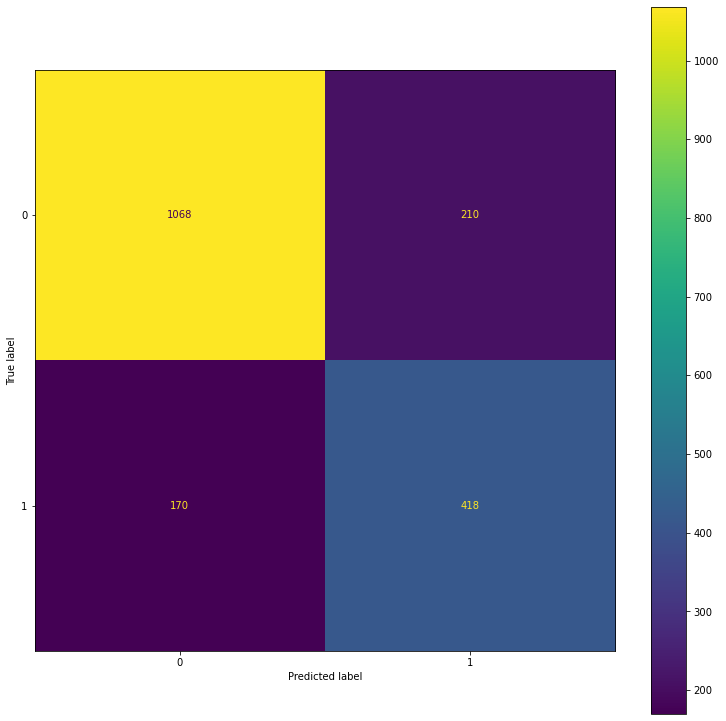

In [30]:
from sklearn import svm

lsvc = svm.LinearSVC()
build_and_eval_model(lsvc, X, y)
# class is imbalanced but not a lot of data is impacting 0 detection better

Running report for model: MultinomialNB(alpha=0.05)
Model accuracy score: 0.7792
macro F-1 score : 0.73418
Training set accuracy score: 0.9910
Test set accuracy score: 0.7792
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1278
           1       0.67      0.58      0.62       588

    accuracy                           0.78      1866
   macro avg       0.75      0.73      0.73      1866
weighted avg       0.77      0.78      0.77      1866

Confusion matrix

 [[1111  167]
 [ 245  343]]

True Positives(TP) =  1111

True Negatives(TN) =  343

False Positives(FP) =  167

False Negatives(FN) =  245
Classification accuracy : 0.7792
Classification error : 0.2208


MultinomialNB(alpha=0.05)

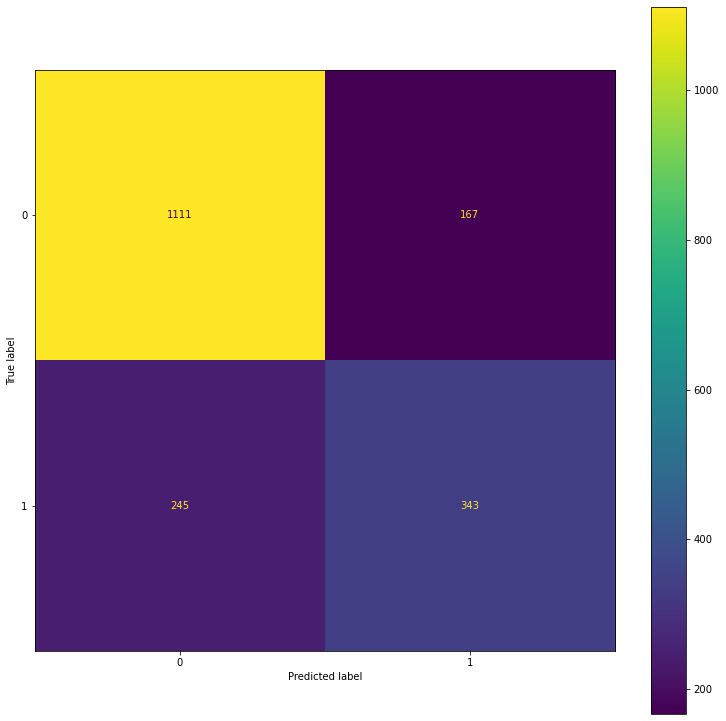

In [31]:
mnb = MultinomialNB(alpha=.05)
#https://stackoverflow.com/questions/52319703/naive-bayes-accuracy-increasing-as-increasing-in-the-alpha-value
build_and_eval_model(mnb, X, y)

Running report for model: SVC()
Model accuracy score: 0.7808
macro F-1 score : 0.7194
Training set accuracy score: 0.9902
Test set accuracy score: 0.7808
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1278
           1       0.72      0.50      0.59       588

    accuracy                           0.78      1866
   macro avg       0.76      0.70      0.72      1866
weighted avg       0.77      0.78      0.77      1866

Confusion matrix

 [[1165  113]
 [ 296  292]]

True Positives(TP) =  1165

True Negatives(TN) =  292

False Positives(FP) =  113

False Negatives(FN) =  296
Classification accuracy : 0.7808
Classification error : 0.2192


SVC()

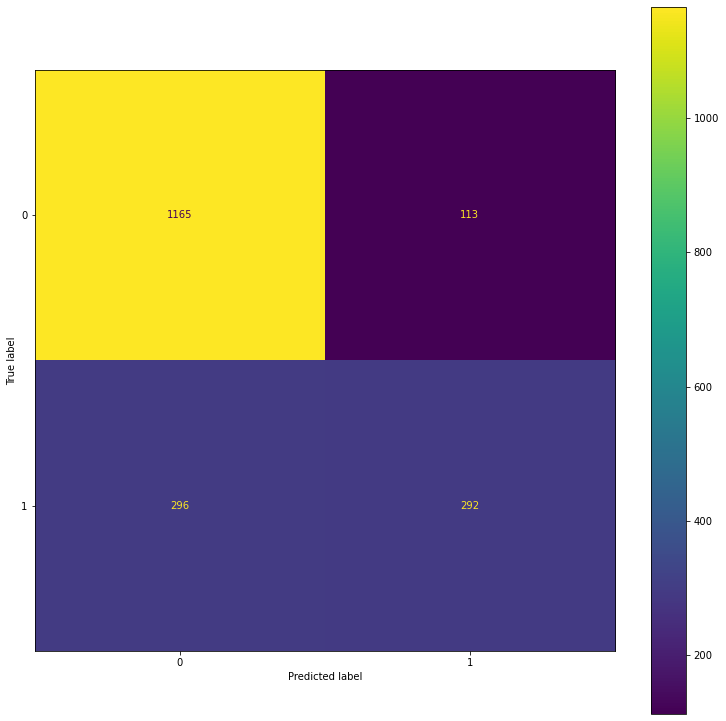

In [32]:
svc = svm.SVC()
build_and_eval_model(svc, X, y)

Running report for model: RandomForestClassifier()
Model accuracy score: 0.7481
macro F-1 score : 0.62812
Training set accuracy score: 0.9918
Test set accuracy score: 0.7481
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      1278
           1       0.77      0.29      0.42       588

    accuracy                           0.75      1866
   macro avg       0.76      0.62      0.63      1866
weighted avg       0.75      0.75      0.71      1866

Confusion matrix

 [[1228   50]
 [ 420  168]]

True Positives(TP) =  1228

True Negatives(TN) =  168

False Positives(FP) =  50

False Negatives(FN) =  420
Classification accuracy : 0.7481
Classification error : 0.2519


RandomForestClassifier()

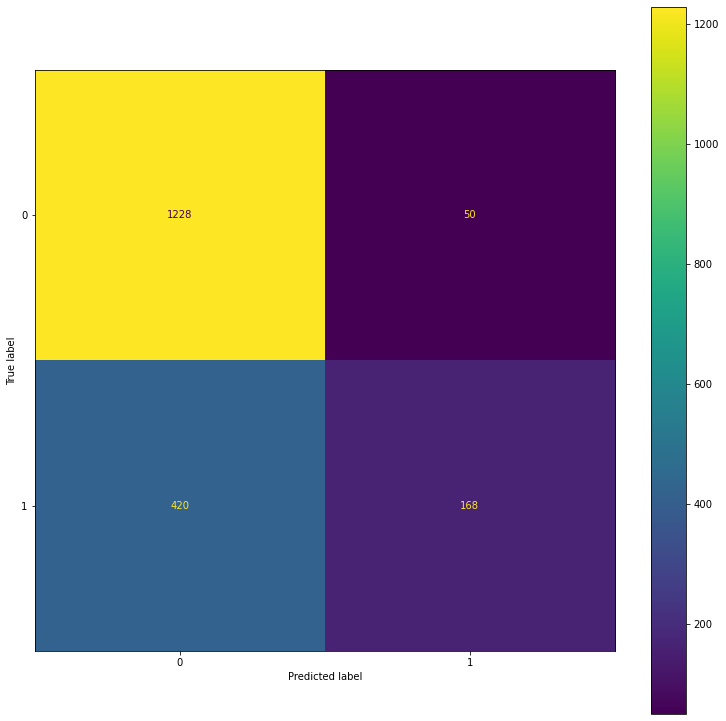

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
build_and_eval_model(rf, X, y)

Running report for model: DecisionTreeClassifier(random_state=0)
Model accuracy score: 0.7235
macro F-1 score : 0.66743
Training set accuracy score: 0.9918
Test set accuracy score: 0.7235
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1278
           1       0.57      0.50      0.53       588

    accuracy                           0.72      1866
   macro avg       0.68      0.66      0.67      1866
weighted avg       0.71      0.72      0.72      1866

Confusion matrix

 [[1058  220]
 [ 296  292]]

True Positives(TP) =  1058

True Negatives(TN) =  292

False Positives(FP) =  220

False Negatives(FN) =  296
Classification accuracy : 0.7235
Classification error : 0.2765


DecisionTreeClassifier(random_state=0)

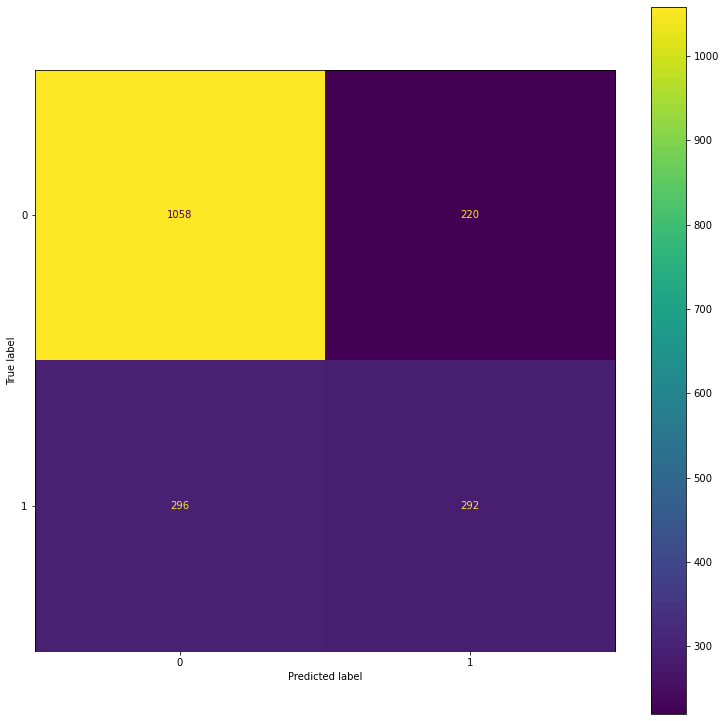

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
build_and_eval_model(dt, X, y)